
## Introduce the Vector Data

Administration data retrieved from [GADM](https://gadm.org/). Download [link](https://geodata.ucdavis.edu/gadm/gadm4.1/shp/gadm41_GRC_shp.zip).

OpenStreetMap (OSM) data downloaded from [geofabrik](download.geofabrik.de). Download [link](https://download.geofabrik.de/europe/greece-latest-free.shp.zip).

In [112]:
# # Data preparation OSM
# labels = ['roads', 'buildings', 'landuse', 'transport']
# bbox=(25, 34, 29, 38)
# p_roads = './data/osm_all/gis_osm_roads_free_1.shp'
# p_buildings = './data/osm_all/gis_osm_buildings_a_free_1.shp'
# p_landuse = './data/osm_all/gis_osm_landuse_a_free_1.shp'
# p_transport = './data/osm_all/gis_osm_transport_a_free_1.shp'

# for label, path in zip(labels, [p_roads, p_buildings, p_landuse, p_transport]):
#     data_crop = gpd.read_file(path, bbox=(25, 34, 29, 38))
#     data_crop.to_parquet(f'{label}.gpkg')

In [113]:
# # # Data preparation GADM
# greece = gpd.read_file('./data/gadm/gadm41_GRC_3.shp')
# greece.to_file('greece.gpkg')

## Get the administration boundary of Rhodes Island

In [114]:
import geopandas as gpd

In [115]:
gdf_greece = gpd.read_file('./data/gadm/greece.gpkg')

In [116]:
gdf_greece

,GID_3,GID_0,COUNTRY,GID_1,NAME_1,NL_NAME_1,GID_2,NAME_2,NL_NAME_2,NAME_3,VARNAME_3,NL_NAME_3,TYPE_3,ENGTYPE_3,CC_3,HASC_3,geometry
0,GRC.1.1.1_1,GRC,Greece,GRC.1_1,Aegean,Αιγαίο,GRC.1.1_1,North Aegean,Βόρειο Αιγαίο,Agios Efstratios,Aghios Efstratios,Αγίου Ευστρατίου,Dímos,Municipality,NA,GR.AI.AE,"MULTIPOLYGON (((25.00375 39.56264, 25.00430 39..."
1,GRC.1.1.2_1,GRC,Greece,GRC.1_1,Aegean,Αιγαίο,GRC.1.1_1,North Aegean,Βόρειο Αιγαίο,Chios,NA,Χίου,Dímos,Municipality,NA,GR.AI.XS,"MULTIPOLYGON (((25.90431 38.22025, 25.90431 38..."
2,GRC.1.1.3_1,GRC,Greece,GRC.1_1,Aegean,Αιγαίο,GRC.1.1_1,North Aegean,Βόρειο Αιγαίο,Fournoi Korseon,Fourni Korseon,Φούρνων Κορσεών,Dímos,Municipality,NA,GR.AI.FK,"MULTIPOLYGON (((26.48931 37.51764, 26.48931 37..."
3,GRC.1.1.4_1,GRC,Greece,GRC.1_1,Aegean,Αιγαίο,GRC.1.1_1,North Aegean,Βόρειο Αιγαίο,Ikaria,Icaria,Ικαριάς,Dímos,Municipality,NA,GR.AI.IK,"POLYGON ((26.02431 37.51653, 26.02431 37.51625..."
4,GRC.1.1.5_1,GRC,Greece,GRC.1_1,Aegean,Αιγαίο,GRC.1.1_1,North Aegean,Βόρειο Αιγαίο,Lemnos,Limnos,Λήμνου,Dímos,Municipality,NA,GR.AI.LM,"MULTIPOLYGON (((25.23597 39.79292, 25.23597 39..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
321,GRC.8.2.21_1,GRC,Greece,GRC.8_1,Thessaly and Central Greece,Θεσσαλία και Στερεά Ελλάδα,GRC.8.2_1,Thessaly,Θεσσαλία,Tempi,Tempes,Τεμπών,Dímos,Municipality,NA,GR.TC.TE,"POLYGON ((22.48664 39.99766, 22.48566 39.99689..."
322,GRC.8.2.22_1,GRC,Greece,GRC.8_1,Thessaly and Central Greece,Θεσσαλία και Στερεά Ελλάδα,GRC.8.2_1,Thessaly,Θεσσαλία,Trikala,NA,Τρικκαίων,Dímos,Municipality,NA,GR.TC.TR,"POLYGON ((21.93094 39.76662, 21.93168 39.76571..."
323,GRC.8.2.23_1,GRC,Greece,GRC.8_1,Thessaly and Central Greece,Θεσσαλία και Στερεά Ελλάδα,GRC.8.2_1,Thessaly,Θεσσαλία,Tyrnavos,NA,Τυρνάβου,Dímos,Municipality,NA,GR.TC.TY,"POLYGON ((22.13472 39.65499, 22.13510 39.65574..."
324,GRC.8.2.24_1,GRC,Greece,GRC.8_1,Thessaly and Central Greece,Θεσσαλία και Στερεά Ελλάδα,GRC.8.2_1,Thessaly,Θεσσαλία,Volos,NA,Βόλου,Dímos,Municipality,NA,GR.TC.VO,"POLYGON ((22.81903 39.27344, 22.81884 39.27332..."


<Axes: >

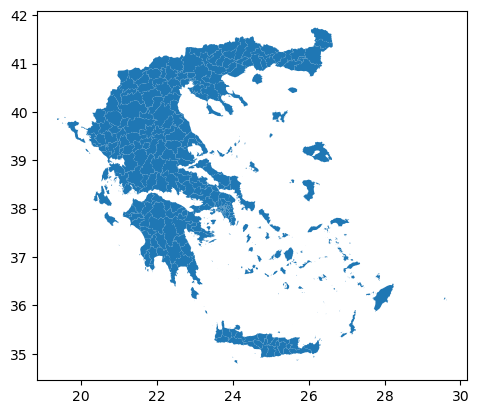

In [117]:
gdf_greece.plot()

In [118]:
gdf_rhodes = gdf_greece.loc[gdf_greece['NAME_3']=='Rhodos']
gdf_rhodes

,GID_3,GID_0,COUNTRY,GID_1,NAME_1,NL_NAME_1,GID_2,NAME_2,NL_NAME_2,NAME_3,VARNAME_3,NL_NAME_3,TYPE_3,ENGTYPE_3,CC_3,HASC_3,geometry
34,GRC.1.2.26_1,GRC,Greece,GRC.1_1,Aegean,Αιγαίο,GRC.1.2_1,South Aegean,Νότιο Αιγαίο,Rhodos,Rhodes,Ρόδου,Dímos,Municipality,NA,GR.AI.RH,"MULTIPOLYGON (((27.75792 35.88792, 27.75903 35..."


<Axes: >

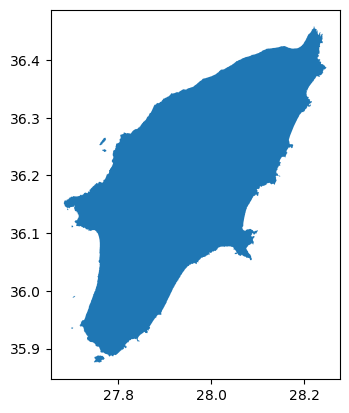

In [119]:
gdf_rhodes.plot()

In [120]:
# Save the rhodes_boundary to gpkg
gdf_rhodes.to_file('data/rhodes.gpkg')

## Get road data from OpenStreetMap

In [121]:
gdf_roads = gpd.read_file('./data/osm/roads.gpkg')

<Axes: >

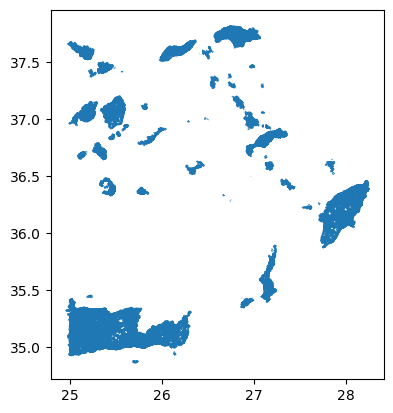

In [122]:
gdf_roads.plot()

In [123]:
# Read data with a mask of Rhodes
gdf_roads = gpd.read_file('./data/osm/roads.gpkg', mask=gdf_rhodes)

<Axes: >

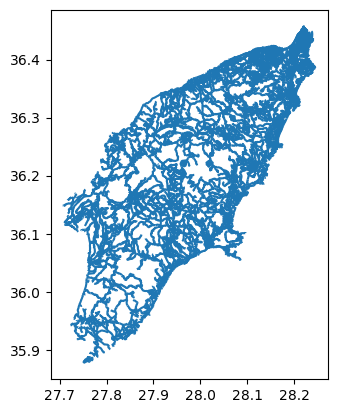

In [124]:
gdf_roads.plot()

In [125]:
gdf_roads

,osm_id,code,fclass,name,ref,oneway,maxspeed,layer,bridge,tunnel,geometry
0,81194256,5121,unclassified,NaN,NaN,B,0,0,F,F,"LINESTRING (27.73144 36.12638, 27.73142 36.126..."
1,172757595,5153,footway,NaN,NaN,B,0,0,F,F,"LINESTRING (27.71921 36.12761, 27.71936 36.127..."
2,239479606,5147,track_grade5,NaN,NaN,B,0,0,F,F,"LINESTRING (27.75890 36.12877, 27.75839 36.128..."
3,239369975,5141,service,NaN,NaN,B,0,0,F,F,"LINESTRING (27.73525 36.12871, 27.73541 36.128..."
4,239369955,5141,service,NaN,NaN,B,0,0,F,F,"LINESTRING (27.73601 36.12897, 27.73591 36.129..."
...,...,...,...,...,...,...,...,...,...,...,...
18879,875722036,5114,secondary,Καλλιθέας,NaN,F,40,0,F,F,"LINESTRING (28.22949 36.41861, 28.22959 36.41855)"
18880,875722037,5114,secondary,Ρόδος - Καλλιθέα,NaN,F,50,0,F,F,"LINESTRING (28.22949 36.41861, 28.22930 36.418..."
18881,920166404,5141,service,NaN,NaN,B,0,0,F,F,"LINESTRING (28.23022 36.41723, 28.23025 36.417..."
18882,920166405,5141,service,NaN,NaN,B,0,0,F,F,"LINESTRING (28.23064 36.41759, 28.23035 36.41759)"


In [126]:
gdf_roads['fclass'].unique()

array(['unclassified', 'footway', 'track_grade5', 'service',
       'residential', 'path', 'track', 'secondary', 'steps', 'tertiary',
       'track_grade2', 'track_grade3', 'track_grade4', 'pedestrian',
       'tertiary_link', 'track_grade1', 'secondary_link', 'primary',
       'living_street', 'primary_link', 'cycleway'], dtype=object)

<Axes: >

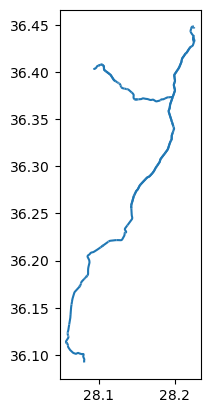

In [127]:
# visulize the primary roads
primary_roads = gdf_roads.loc[gdf_roads['fclass']=='primary']
primary_roads.plot()

In [128]:
# Extract infrastratcure roads with a loop 
infra_labels = ['primary', 'secondary', 'tertiary']

infra_roads = gdf_roads.loc[gdf_roads['fclass'].isin(infra_labels)]

<Axes: >

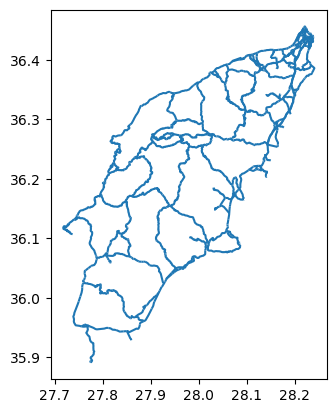

In [129]:
infra_roads.plot()

## Make 100m buffer around the infrastructure roads

To make a 100m buffer, we need first transform the data into a CRS with length unit. For example [GGRS87](https://epsg.io/2100), with EPSG code 2100.

In [130]:
# Covert to a crs with meters unit
infra_roads_meters = infra_roads.to_crs(2100)

In [131]:
# Create buffer, note that the gdf changed to a GeoSeries
infra_roads_meters_buffer = infra_roads_meters.buffer(100)
infra_roads_meters_buffer

45       POLYGON ((835416.042 4003863.922, 835427.364 4...
58       POLYGON ((834402.929 4003012.515, 834401.865 4...
99       POLYGON ((838546.789 3984903.614, 838553.301 3...
100      POLYGON ((839682.491 3984773.465, 839679.219 3...
108      POLYGON ((839650.528 3984897.525, 839646.746 3...
                               ...                        
18876    POLYGON ((879037.642 4038438.581, 879042.908 4...
18877    POLYGON ((879007.931 4038379.355, 879012.724 4...
18878    POLYGON ((879045.833 4038454.892, 879050.667 4...
18879    POLYGON ((879188.948 4038486.610, 879196.752 4...
18880    POLYGON ((879190.669 4038322.167, 879181.177 4...
Length: 1369, dtype: geometry

In [132]:
infra_roads_buffer  = infra_roads_meters_buffer.to_crs(4326)
infra_roads_buffer

45       POLYGON ((27.72826 36.12409, 27.72839 36.12426...
58       POLYGON ((27.71666 36.11678, 27.71665 36.11678...
99       POLYGON ((27.75485 35.95242, 27.75493 35.95248...
100      POLYGON ((27.76737 35.95086, 27.76733 35.95086...
108      POLYGON ((27.76706 35.95199, 27.76702 35.95201...
                               ...                        
18876    POLYGON ((28.22855 36.41890, 28.22861 36.41899...
18877    POLYGON ((28.22819 36.41838, 28.22825 36.41845...
18878    POLYGON ((28.22865 36.41904, 28.22871 36.41912...
18879    POLYGON ((28.23026 36.41927, 28.23034 36.41921...
18880    POLYGON ((28.23020 36.41779, 28.23007 36.41745...
Length: 1369, dtype: geometry

<Axes: >

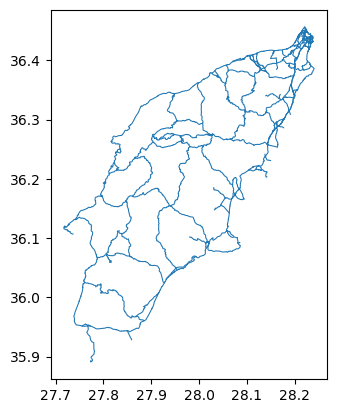

In [133]:
infra_roads_buffer.plot()

In [134]:
def buffer_crs(gdf, size, meter_crs=2100, target_crs=4326):
    return gdf.to_crs(meter_crs).buffer(size).to_crs(target_crs)

In [135]:
infra_roads_buffer = buffer_crs(infra_roads, 100)
infra_roads_buffer

45       POLYGON ((27.72826 36.12409, 27.72839 36.12426...
58       POLYGON ((27.71666 36.11678, 27.71665 36.11678...
99       POLYGON ((27.75485 35.95242, 27.75493 35.95248...
100      POLYGON ((27.76737 35.95086, 27.76733 35.95086...
108      POLYGON ((27.76706 35.95199, 27.76702 35.95201...
                               ...                        
18876    POLYGON ((28.22855 36.41890, 28.22861 36.41899...
18877    POLYGON ((28.22819 36.41838, 28.22825 36.41845...
18878    POLYGON ((28.22865 36.41904, 28.22871 36.41912...
18879    POLYGON ((28.23026 36.41927, 28.23034 36.41921...
18880    POLYGON ((28.23020 36.41779, 28.23007 36.41745...
Length: 1369, dtype: geometry

In [136]:
infra_roads_buffer.to_file('data/infra_roads_100mbuffer.gpkg')

## Load build-up regions

In [137]:
gdf_landuse = gpd.read_file('./data/osm/landuse.gpkg', mask=gdf_rhodes)

In [138]:
gdf_landuse

,osm_id,code,fclass,name,geometry
0,283545932,7229,farmland,NaN,"POLYGON ((27.73565 35.95070, 27.73584 35.95094..."
1,353822382,7217,scrub,NaN,"POLYGON ((27.74374 35.94771, 27.74396 35.94807..."
2,3216678,7210,nature_reserve,Πρασονήσι,"POLYGON ((27.74959 35.87780, 27.74985 35.87809..."
3,283545953,7229,farmland,NaN,"POLYGON ((27.75138 35.95258, 27.75274 35.95223..."
4,1196920676,7201,forest,NaN,"POLYGON ((27.75293 35.88491, 27.75330 35.88439..."
...,...,...,...,...,...
6102,166093057,7217,scrub,NaN,"POLYGON ((28.22847 36.42133, 28.22871 36.42164..."
6103,920075982,7217,scrub,NaN,"POLYGON ((28.22852 36.42273, 28.22856 36.42289..."
6104,274255807,7203,residential,NaN,"POLYGON ((28.22865 36.41992, 28.22920 36.41993..."
6105,361451567,7217,scrub,NaN,"POLYGON ((28.22920 36.41920, 28.22922 36.41940..."


In [139]:
# Find the unique land use 
gdf_landuse['fclass'].unique()

array(['farmland', 'scrub', 'nature_reserve', 'forest', 'industrial',
       'farmyard', 'orchard', 'grass', 'residential', 'commercial',
       'retail', 'cemetery', 'heath', 'meadow', 'recreation_ground',
       'quarry', 'military', 'park', 'vineyard'], dtype=object)

<Axes: >

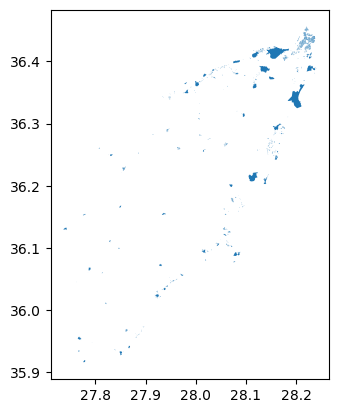

In [140]:
# Exercise: select and built up areas from landuse.gpkg 

# Define built-up labels
builtup_labels = ['commercial', 'industrial', 'residential' ]

# Select built up area
builtup_landuse = gdf_landuse.loc[gdf_landuse['fclass'].isin(builtup_labels)]

builtup_landuse.plot()

In [141]:
builtup_landuse

,osm_id,code,fclass,name,geometry
11,238647753,7204,industrial,NaN,"POLYGON ((27.76578 35.93404, 27.76633 35.93451..."
78,376514386,7204,industrial,NaN,"POLYGON ((27.83789 35.93674, 27.83827 35.93719..."
106,978073993,7203,residential,NaN,"POLYGON ((27.84768 35.93296, 27.84813 35.93316..."
116,353804288,7203,residential,NaN,"POLYGON ((27.85547 35.93281, 27.85607 35.93302..."
134,353804304,7209,commercial,Atrium Prestige Thalasso Spa & Villas,"POLYGON ((27.86529 35.94081, 27.86536 35.94092..."
...,...,...,...,...,...
6097,274255813,7203,residential,NaN,"POLYGON ((28.22707 36.42278, 28.22770 36.42360..."
6098,274255812,7203,residential,NaN,"POLYGON ((28.22766 36.42223, 28.22815 36.42291..."
6100,274255782,7203,residential,NaN,"POLYGON ((28.22817 36.42005, 28.22817 36.42051..."
6101,274255831,7203,residential,NaN,"POLYGON ((28.22830 36.42106, 28.22868 36.42106..."


In [142]:
builtup_buildings = gpd.read_file('./data/osm/buildings.gpkg', mask=gdf_rhodes)

<Axes: >

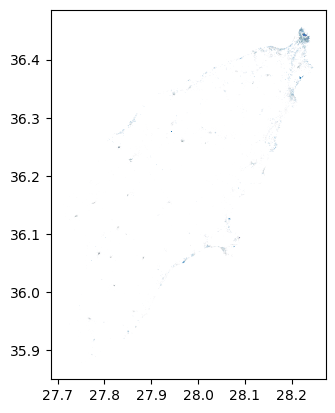

In [143]:
builtup_buildings.plot()

<Axes: >

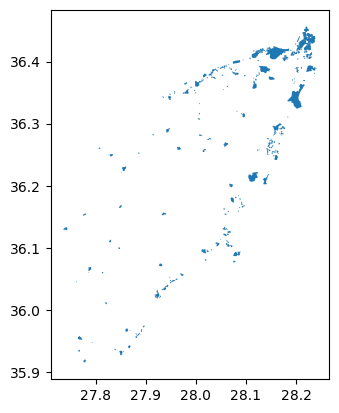

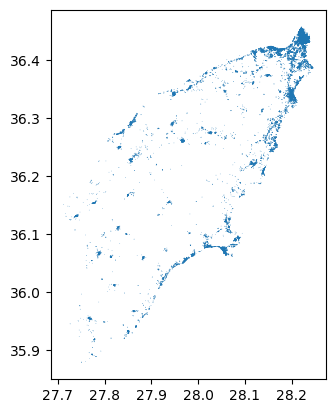

In [144]:
# Exercise: Make 50m buffer for the "builtup_buildings" and "builtup_buildings" using buffer_crs function
builtup_landuse_buffer = buffer_crs(builtup_landuse, 50)
builtup_buildings_buffer = buffer_crs(builtup_buildings, 50)

builtup_landuse_buffer.plot()
builtup_buildings_buffer.plot()

In [145]:
import pandas as pd
builtup = pd.concat([builtup, builtup_buildings_buffer])
builtup

11       POLYGON ((27.76382 35.93320, 27.76382 35.93320...
78       POLYGON ((27.83653 35.93531, 27.83653 35.93532...
106      POLYGON ((27.84602 35.93177, 27.84601 35.93178...
116      POLYGON ((27.85357 35.93189, 27.85357 35.93189...
134      POLYGON ((27.86363 35.93962, 27.86363 35.93962...
                               ...                        
22020    POLYGON ((28.22533 36.43218, 28.22528 36.43220...
22021    POLYGON ((28.22553 36.43312, 28.22548 36.43314...
22022    POLYGON ((28.22564 36.43195, 28.22559 36.43197...
22023    POLYGON ((28.22571 36.43208, 28.22566 36.43210...
22024    POLYGON ((28.22555 36.43210, 28.22555 36.43210...
Length: 45400, dtype: geometry

In [146]:
# Make a for loop to append buffers from different sources
builtup = None
list_gdf = [builtup_landuse, builtup_buildings]
for gdf in list_gdf:
    if builtup is None:
        builtup = buffer_crs(gdf, 50)
    else:
        gdf_buffer = buffer_crs(gdf, 50)
        builtup = pd.concat([builtup, gdf_buffer])

In [148]:
# Exercise: include transport data into builtup area
builtup_tranport = gpd.read_file('./data/osm/transport.gpkg', mask=gdf_rhodes)

builtup = None
list_gdf = [builtup_landuse, builtup_buildings, builtup_tranport]
for gdf in list_gdf:
    if builtup is None:
        builtup = buffer_crs(gdf, 50)
    else:
        gdf_buffer = buffer_crs(gdf, 50)
        builtup = pd.concat([builtup, gdf_buffer])

In [149]:
builtup.to_file('data/builtup_50mbuffer.gpkg')